In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess
import corner

from astropy.time import Time
import astropy.units as u
import astropy.constants as c

import time as timer


tangerine = ['#1a2754','#f9a919','#2ab59f','#e2721c','#db3e0e','#067bc1']

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['figure.figsize'] = 4,3
mpl.rcParams['legend.fancybox'] = False


In [2]:
def normalize_lc(flux):
    #Returns median-normalized flux in units of parts-per-thousand
    mu = np.nanmedian(flux)
    return (flux/mu - 1) * 1e3


# **TESS TICA light curve**



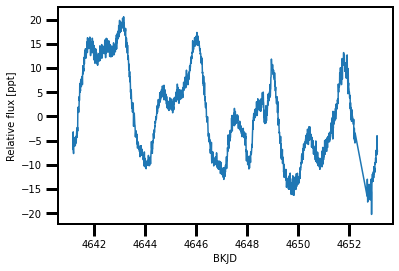

In [3]:
#Note: upload the TICA light curve from the file manager at left
tica = np.loadtxt('v1298_s43_o1.txt')
tess_mjd  = tica[:,0] 
tess_f1   = tica[:,1]
tess_f2   = tica[:,2]
tess_f3   = tica[:,3]

tess_f1 = normalize_lc(tess_f1)
tess_f2 = normalize_lc(tess_f2)
tess_f3 = normalize_lc(tess_f3)

from astropy.time import Time
tess_bjd  = Time(tess_mjd, format='mjd').jd
tess_bkjd = tess_bjd - 2454833.0

#Ben: 
#On timing: the TICA data come in genuine MJDs, so there's a 0.5 day offset 
#to be corrected out in the conversion to BJDs---should be BJD +2457000 - 2400000.5 =  56999.5 days
#of offset to account for between the two standards.

#Also worth noting these timestamps are not barycentric corrected, they're given in the rest frame of TESS. 
#Easy enough for future us to calculate the offset and apply it, but as of right now that's up to 8 minutes of extra slop.

tess_beg = tess_bkjd.min()
tess_end = tess_bkjd.max()
tess_mission_flag = ['tess']*len(tess_bkjd)
tess_texp = np.median(np.diff(tess_bkjd))

x = tess_bkjd
y = tess_f1

x = np.ascontiguousarray(x, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)

mission_flag = tess_mission_flag

plt.plot(x,y)
plt.xlabel("BKJD")
plt.ylabel("Relative flux [ppt]")
plt.show()


# **TESS TICA light curve v2** 
From Ben: Here's an updated extraction of the light curve. First column is time, middle column is the best extraction I can do in terms of minimizing noise, but at the expense of more contamination between the three stars, and right column is the best I can do at separating out the three stars to produce a pure V1298 Tau signal. I think my advice is to use the middle column to get precise timing but to not believe any signals unless they're also in the right column. I think the middle one looks pretty good at the times we care about!


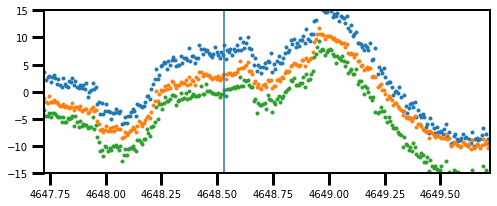

In [4]:
tica2 = np.loadtxt('v1298_s43_o1_v2.txt')

tica2_mjd  = tica2[:,0] 
tica2_bjd  = Time(tica2_mjd, format='mjd').jd
tica2_bkjd = tica2_bjd - 2454833.0

tica2_f1   = normalize_lc(tica2[:,1])
tica2_f2   = normalize_lc(tica2[:,2])

plt.plot(tess_bkjd, tess_f1+5, '.')
plt.plot(tica2_bkjd, tica2_f1, '.')
plt.plot(tica2_bkjd, tica2_f2-2, '.')
#plt.xlim(4645.39920514-0.5,4645.39920514+0.5)
plt.xlim(4648.72281079-1, 4648.72281079+1)
#plt.ylim(-5,10)
plt.ylim(-15,15)
plt.axvline(4648.53)
plt.gcf().set_size_inches(8,3)
plt.show()

In [5]:
#Stellar parameters
M_star  = 1.10, 0.05
R_star  = 1.305, 0.07

include_planet_e = True

if include_planet_e == True:    
    
    #Livingston ephemeris
    t0s     = np.array([2231.281202, 2239.400529, 2234.046461, 2263.6229])
    periods = np.array([8.249147, 12.401369,  24.141445, 36.695032307689445])    

    
    #If planet c is overlapping with planet e
    #t0s = np.array([4648.75, 4645.4, 4648.1, 4648.8])    
    #periods = np.array([8.250746750853242, 12.402059128865977,  24.140535390000004, 36.695032307689445])

    #t0s = np.array([4648.281273, 4645.4,4648.1,4648.8])
    #periods = np.array([8.249147, 12.402059128865977,  24.140535390000004, 36.695032307689445])

    # t0s     = np.array([4648.281273, 4645.4, 4648.1, 4648.8]) #Livingston ephemeris
    # periods = np.array([8.249147, 12.401369,  24.141445, 36.695032307689445])    

    rors    = np.array([0.0381, 0.0436, 0.0700, 0.0611])
    depths  = np.array(1e3*(rors**2))
    t14s    = np.array([4.66, 5.59, 6.42, 7.45])/24.0

elif include_planet_e == False:
    t0s     = np.array([2231.281202, 2239.400529, 2234.046461])# - x_ref
    periods = np.array([8.249147, 12.401369,  24.141445])
    rors    = np.array([0.0381, 0.0436, 0.0700])
    depths  = np.array(1e3*(rors**2))    

# Number of planets to be included in fit
n_pl = len(t0s)

# Compute the expected transit times for a linear ephemeris
expected_transit_times = xo.orbits.ttv.compute_expected_transit_times(
    x.min(), x.max(), periods, t0s
)

### Before we start fitting the light curve let's see if we can identify the transits by eye

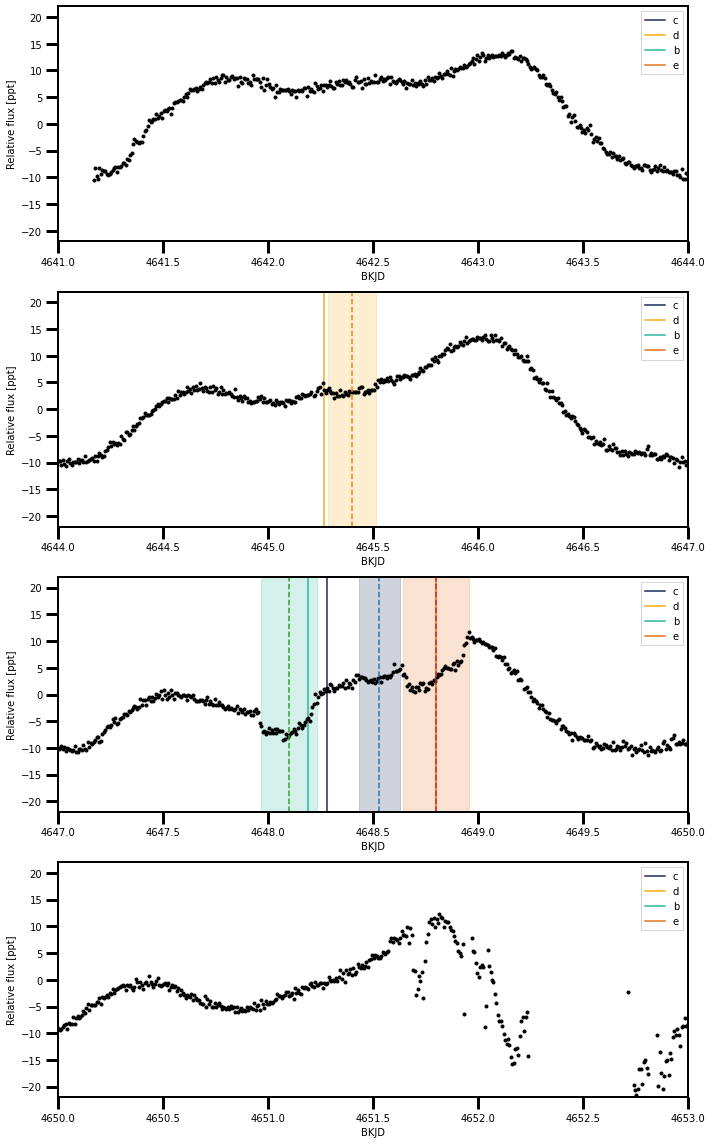

In [6]:
nrows = 4
xmin = int(tess_bkjd.min()) + 3*np.arange(nrows)

fig,axes = plt.subplots(nrows=nrows, ncols=1, figsize=(10,4*nrows))

for n in range(nrows):
    ax = axes[n]

    for i,let in enumerate("cdbe"):
        ttimes = expected_transit_times[i]
        for _tt in ttimes:
            if (_tt>tess_bkjd.min()) & (_tt<tess_bkjd.max()):
                ax.axvline(_tt, color=tangerine[i], label=let)

    #ax.plot(x, y, 'k.')
    ax.plot(tica2_bkjd, tica2_f1, 'k.')

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    #for k,tmid in enumerate(expected_transit_times):
      #ax.axvspan(tmid[0]-0.5*t14s[k], tmid[0]+0.5*t14s[k], alpha=0.2, color=tangerine[k])

    for k,tmid in enumerate([4648.53, 4645.4, 4648.1, 4648.8]):
      ax.axvspan(tmid-0.5*t14s[k], tmid+0.5*t14s[k], alpha=0.2, color=tangerine[k])

    
    # Where we think the TESS transits are
    ax.axvline(4648.53, color='C0', ls='--') # planet c
    ax.axvline(4645.4, color='C1', ls='--') # planet d
    ax.axvline(4648.1, color='C2', ls='--') # planet b
    ax.axvline(4648.8, color='C3', ls='--') # planet e

    ax.set_xlim(xmin[n], xmin[n]+3)
    ax.set_ylim(-22,22)
    ax.set_xlabel("BKJD")
    ax.set_ylabel("Relative flux [ppt]")

plt.tight_layout()
plt.show()

It looks like: 

1. Planet d arrives late at BKJD = 4645.4
2. Planet b arrives early at BKJD = 4648.1
3. Planet c arrives late at BKJD = 4648.53? There is a dip right before the ingress of planet e, with seemingly the right duration. It's hard to tell for sure because the noise changes significantly around the transit.
4. Planet e transits around BKJD = 4648.8 


The data beyond BKJD = 4651.5 are corrupted so let's remove it.

# **The SimpleTransitOrbit model** (fitting in terms of duration)


In [7]:
periods   = np.array([8.249147, 12.401369,  24.141445, 36.695032307689445])    
t0s       = np.array([4648.53, 4645.4, 4648.1, 4648.8])
rors      = np.array([0.0381, 0.0436, 0.0700, 0.0611])
depths    = np.array(1e3*(rors**2))
durations = np.array([4.66, 5.59, 6.42, 7.45])/24.0
n_pl      = len(periods)
R_star    = 1.305, 0.07


x = tica2_bkjd
y = tica2_f1
m = (np.isfinite(x)) & (np.isfinite(y)) & (x<4651.5)

x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)

# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)


def depth_duration_model():


  with pm.Model() as model:

    # Physical parameters that will be sampled
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
    r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
    u_star = xo.QuadLimbDark("u_star")
    star = xo.LimbDarkLightCurve(u_star)
    b = pm.Uniform("b", lower=0, upper=1, shape=n_pl)
    t0 = pm.Normal("t0", mu=t0s, sigma=0.1, shape=n_pl)
    log_period = pm.Normal("log_period", mu=np.log(periods), sigma=1, shape=n_pl)
    log_depth = pm.Normal("log_depth", mu=np.log(depths), sigma=1, shape=n_pl)
    log_duration = pm.Normal("log_duration", mu=np.log(durations), sigma=1, shape=n_pl)
                            
    # Track parameters of interest as deterministics
    duration = pm.Deterministic("duration", tt.exp(log_duration))
    period = pm.Deterministic("period", tt.exp(log_period))
    ror = pm.Deterministic("ror", 
                                star.get_ror_from_approx_transit_depth(
                                    1e-3 * tt.exp(log_depth), b
                                ),
                                )
    r_pl = pm.Deterministic("r_pl", ror * r_star)
    r_pl_rade = pm.Deterministic("r_pl_rade", ror * r_star * c.R_sun/c.R_earth)  

    #Set up the orbit
    orbit = xo.orbits.SimpleTransitOrbit(
        period=period, 
        duration=duration, 
        t0=t0, 
        b=b, 
        r_star=r_star
      )
    
    #Compute the light curve model
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    light_curves = (
        star.get_light_curve(
            orbit=orbit, 
            r=r_pl, 
            t=x, 
            texp=tess_texp) * 1e3
          )
    
    light_curve = pm.math.sum(light_curves, axis=-1)  + mean
          
    # Quadratic trend for varying background flux
    trend = pm.Normal(
        "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
    )
    # Define the background model
    A = np.vander(x, 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))        
          
    resid = y - light_curve - bkg

    # Light curve noise and in-transit jitter
    log_sigma_lc  = pm.Normal("log_sigma_lc", mu=np.log(0.01*np.std(y)), sd=10)
    log_sigma_jit = pm.Normal("log_sigma_jit", mu=np.log(0.01*np.std(y)), sd=10) 
    yerr = pm.Deterministic("yerr", tt.exp(log_sigma_lc) + tt.exp(2*log_sigma_jit)*(light_curve**2))


    # The parameters of the first SHO term
    log_rho_sho = pm.Normal("log_rho_sho", mu=0.0, sd=10)
    log_sigma_sho = pm.Normal("log_sigma_sho", mu=np.log(np.std(y)), sd=10)

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period_rot = pm.Normal("log_period_rot", mu=np.log(2.87), sigma=2.0)
    period_rot = pm.Deterministic("period_rot", tt.exp(log_period_rot))
    log_Q0_rot = pm.HalfNormal("log_Q0_rot", sigma=2.0)
    log_dQ_rot = pm.Normal("log_dQ_rot", mu=0.0, sigma=2.0)
    f_rot = pm.Uniform("f_rot", lower=0.1, upper=1.0)

    # GP model for the light curve
    kernel_tess = terms.SHOTerm(
        sigma=tt.exp(log_sigma_sho),
        rho=tt.exp(log_rho_sho),
        Q=1/np.sqrt(2),
      )
    kernel_tess += terms.RotationTerm(
                      sigma=sigma_rot,
                      period=period_rot,
                      Q0=tt.exp(log_Q0_rot),
                      dQ=tt.exp(log_dQ_rot),
                      f=f_rot,
                  )

    gp = GaussianProcess(kernel_tess, t=x, yerr=yerr)
    gp.marginal("transit_obs", observed=resid)  


    # Compute and save the phased light curve models
    pm.Deterministic(
        "lc_pred",
        1e3
        * tt.stack(
            [
                star.get_light_curve(
                    orbit=orbit, r=r_pl, t=t0[n] + phase_lc, texp=tess_texp
                )[..., n]
                for n in range(n_pl)
            ],
            axis=-1,
        ),
    )  

    # Perform optimization
    map_soln = model.test_point
    
    map_soln = pmx.optimize(start=map_soln, 
                            vars=[sigma_rot,
                                  log_period_rot,
                                  log_Q0_rot,
                                  log_dQ_rot,
                                  f_rot,
                                  mean,
                                  ]
                            )    
    
    
    map_soln = pmx.optimize(start=map_soln, 
                            vars=trend)
    map_soln = pmx.optimize(start=map_soln, 
                            vars=[b, log_depth, log_duration])
    map_soln = pmx.optimize(start=map_soln, 
                            vars=t0)

    map_soln = pmx.optimize(start=map_soln, 
                            vars=[log_rho_sho,
                                  log_sigma_sho,
                                  ]
                            )
    map_soln = pmx.optimize(start=map_soln, 
                            )  

    # Package the MAP light curve and GP prediction
    extras = dict(
        zip(
            ["light_curves", 
              "gp_pred"],
            pmx.eval_in_model([light_curves,
                                gp.predict(resid)], map_soln),
        )
    )

    return model, map_soln, extras, orbit


model0, map_soln0, extras0, orbit0 = depth_duration_model()

optimizing logp for variables: [mean, f_rot, log_dQ_rot, log_Q0_rot, log_period_rot, sigma_rot]


message: Desired error not necessarily achieved due to precision loss.
logp: -19057.069699551637 -> -1427.4577525925895
optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -1427.4577525925895 -> -1424.286071570129
optimizing logp for variables: [log_duration, log_depth, b]


message: Desired error not necessarily achieved due to precision loss.
logp: -1424.286071570129 -> -1397.9892835190144
optimizing logp for variables: [t0]


message: Desired error not necessarily achieved due to precision loss.
logp: -1397.9892835190144 -> -1397.7971346699678
optimizing logp for variables: [log_sigma_sho, log_rho_sho]


message: Desired error not necessarily achieved due to precision loss.
logp: -1397.7971346699678 -> -1309.8509028163069
optimizing logp for variables: [f_rot, log_dQ_rot, log_Q0_rot, log_period_rot, sigma_rot, log_sigma_sho, log_rho_sho, log_sigma_jit, log_sigma_lc, trend, mean, log_duration, log_depth, log_period, t0, b, u_star, r_star]


message: Desired error not necessarily achieved due to precision loss.
logp: -1309.8509028163069 -> -1290.2536110951241


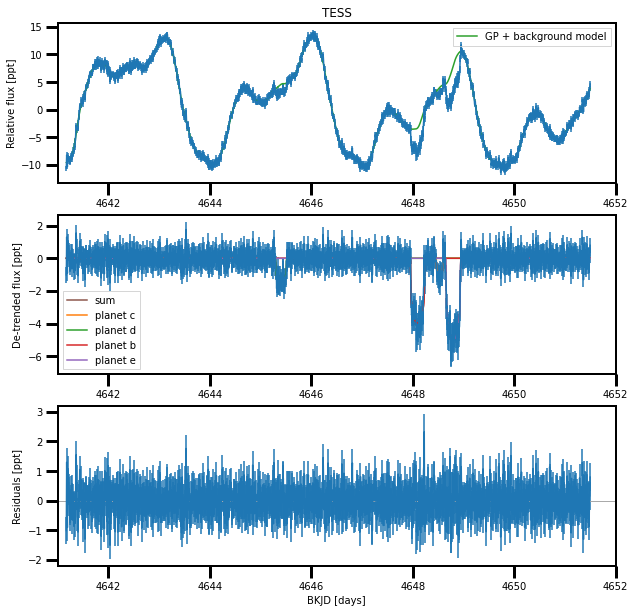

In [11]:
def plot_light_curve(soln, extras, xrange=[4641,4652], mask=None):


    if mask is None:
        mask = np.ones(len(x), dtype=bool)
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

        
    ax = axes[0]
    ax.errorbar(x[mask], y[mask], yerr=soln["yerr"])#, **ebar_kws)
    gp_mod = extras["gp_pred"] + soln["mean"] + soln["bkg"]
    ax.plot(x[mask], gp_mod, color="C2", label="GP + background model")
    ax.legend(fontsize=10)
    ax.set_ylabel("Relative flux [ppt]")
    
    ax.set_title('TESS')

    ax = axes[1]
    ax.errorbar(x[mask], y[mask] - gp_mod, yerr=soln["yerr"])#,  **ebar_kws)

    mod_sum = np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], mod_sum, label="sum", color="C5")
    
    for i, l in enumerate("cdbe"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
        
    
        
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("De-trended flux [ppt]")
    

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.errorbar(x[mask], y[mask] - mod, yerr=soln["yerr"])#,  **ebar_kws)
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("Residuals [ppt]")
    ax.set_xlabel("BKJD [days]")
    
    for i in range(3):
        axes[i].set_xlim(xrange[0],xrange[1])
    

    return fig
 

_ = plot_light_curve(map_soln0, extras0)

In [12]:
with model0:
  pmx.sample()

//anaconda3/lib/python3.7/site-packages/pymc3_ext/sampling/sampling.py:97: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return pm.sample(draws=draws, tune=tune, model=model, step=step, **kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rot, log_dQ_rot, log_Q0_rot, log_period_rot, sigma_rot, log_sigma_sho, log_rho_sho, log_sigma_jit, log_sigma_lc, trend, mean, log_duration, log_depth, log_period, t0, b, u_star, r_star]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7814 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9768795241820303, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9999998867483699, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
phase_lc = np.linspace(-0.3, 0.3, 100)

# Required changes:
# We can have different depths for K2 and TESS





def build_model(mask=None, 
                start=None,
                ttvs=False,
                eccentric=False):
    
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    with pm.Model() as model:

        # Parameters for the stellar properties
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])        
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1, shape=n_pl)
        
        #log_depth_tess = pm.Normal("log_depth_tess", mu=np.log(depths), sigma=2.0, shape=n_pl)                
        log_depth_tess = pm.Normal("log_depth_tess", mu=np.log(depths), sigma=1e-6, shape=n_pl)                        
        ror_tess = pm.Deterministic("ror_tess", 
                                    star.get_ror_from_approx_transit_depth(
                                        1e-3 * tt.exp(log_depth_tess), b
                                    ),
                                   )
                    
        r_pl_tess = pm.Deterministic("r_pl_tess", ror_tess * r_star)
        r_pl_rade = pm.Deterministic("r_pl_rade", ror_tess * r_star * c.R_sun/c.R_earth)

        
        # Eccentricity and longitude of periastron
        if eccentric==True:
            ecs = pmx.UnitDisk("ecs", shape=(2, n_pl), testval=0.01 * np.ones((2, n_pl)))
            ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
            omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
            xo.eccentricity.vaneylen19("ecc_prior", 
                                    multi=True, shape=n_pl, fixed=True, observed=ecc)
    
        elif eccentric==False:
            ecc = np.zeros(n_pl)
            omega = np.pi/2*np.ones(n_pl)


        if ttvs==True:
            # Now we have a parameter for each transit time of each planet:
            transit_times = []
            for i in range(n_pl):
                transit_times.append(
                    pm.Normal(
                        "tts_{0}".format(i),
                        mu=expected_transit_times[i],
                        sd=1, #Change this back to 0.1 to work
                        shape=len(expected_transit_times[i]),
                    )
                )

            # Set up an orbit for the planets
            orbit = xo.orbits.TTVOrbit(
                r_star=r_star,
                m_star=m_star,
                b=b,
                ecc=ecc,
                omega=omega,
                transit_times=transit_times)

            # It will be useful later to track some parameters of the orbit
            pm.Deterministic("t0", orbit.t0)
            pm.Deterministic("period", orbit.period)
            
        elif ttvs==False:
            
            # Orbital parameters for the planets
            t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=n_pl)
            log_period = pm.Normal("log_period", mu=np.log(periods), sd=1, shape=n_pl)
            period = pm.Deterministic("period", tt.exp(log_period))

            # Orbit models
            orbit = xo.orbits.KeplerianOrbit(
                r_star=r_star,
                m_star=m_star,
                period=period,
                t0=t0,
                b=b,
                ecc=ecc,
                omega=omega,
            )

        ########################################################################################        
        ########################################################################################
        # Compute the model light curve
        mean_tess = pm.Normal("mean_tess", mu=0.0, sd=10.0)
        
        # Quadratic trend for varying background flux
        trend = pm.Normal(
            "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
        )
        # Define the background model
        A = np.vander(x, 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))        
        
        light_curves_tess = (
            star.get_light_curve(
                orbit=orbit, 
                r=r_pl_tess, 
                t=x[mask], 
                texp=tess_texp) * 1e3
        )
        light_curve_tess = pm.math.sum(light_curves_tess, axis=-1) + mean_tess
        resid_tess = y[mask] - light_curve_tess - bkg[mask]

        # Transit jitter & GP parameters
        log_sigma_lc_tess  = pm.Normal("log_sigma_lc_tess", mu=np.log(0.01*np.std(y[mask])), sd=10)
        log_sigma_jit_tess = pm.Normal("log_sigma_jit_tess", mu=np.log(0.02*np.std(y[mask])), sd=10) 
        yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess) + tt.exp(2*log_sigma_jit_tess)*(light_curve_tess**2))
        #yerr_tess = pm.Deterministic("yerr_tess", tt.exp(log_sigma_lc_tess))

        #The parameters of the RotationTerm kernel
        sigma_rot_tess = pm.InverseGamma(
            "sigma_rot_tess", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period_rot_tess = pm.Normal("log_period_rot_tess", mu=np.log(2.87), sigma=2.0)
        period_rot_tess = pm.Deterministic("period_rot_tess", tt.exp(log_period_rot_tess))
        log_Q0_rot_tess = pm.HalfNormal("log_Q0_rot_tess", sigma=2.0)
        log_dQ_rot_tess = pm.Normal("log_dQ_rot_tess", mu=0.0, sigma=2.0)
        f_rot_tess = pm.Uniform("f_rot_tess", lower=0.1, upper=1.0)
    
        kernel_tess = terms.RotationTerm(
                    sigma=sigma_rot_tess,
                    period=period_rot_tess,
                    Q0=tt.exp(log_Q0_rot_tess),
                    dQ=tt.exp(log_dQ_rot_tess),
                    f=f_rot_tess,
                )

        gp_tess = GaussianProcess(kernel_tess, t=x[mask], yerr=yerr_tess)
        gp_tess.marginal("transit_obs_tess", observed=resid_tess)        

        if ttvs==False:
            #Compute and save the phased light curve models
            pm.Deterministic(
                "lc_pred",
                1e3
                * tt.stack(
                    [
                        star.get_light_curve(
                            orbit=orbit, r=r_pl_tess, t=t0[n] + phase_lc, texp=tess_texp
                        )[..., n]
                        for n in range(n_pl)
                    ],
                    axis=-1,
                ),
            )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        
        map_soln = pmx.optimize(start=start, 
                                vars=trend)
        
        if ttvs==True:
            map_soln = pmx.optimize(start=map_soln, vars=transit_times)
        elif ttvs==False:
            map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[b,
                                      log_depth_tess])
        
        
        map_soln = pmx.optimize(start=map_soln, 
                                vars=[sigma_rot_tess,
                                      log_period_rot_tess,
                                      log_Q0_rot_tess,
                                      log_dQ_rot_tess,
                                      f_rot_tess,
                                      mean_tess,
                                      ]
                               )
        
        
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves_tess", 
                 "gp_pred_tess"],
                pmx.eval_in_model([light_curves_tess,
                                   gp_tess.predict(resid_tess)], map_soln),
            )
        )

    return model, map_soln, extras, orbit

model0, map_soln0, extras0, orbit0 = build_model(ttvs=False)

optimizing logp for variables: [trend]


message: Desired error not necessarily achieved due to precision loss.
logp: -32984.22667537213 -> -32945.89006909021
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -32945.89006909021 -> -31391.89517982106
optimizing logp for variables: [log_depth_tess, b]


message: Desired error not necessarily achieved due to precision loss.
logp: -31391.89517982106 -> -31391.826910836426
optimizing logp for variables: [mean_tess, f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess]


message: Desired error not necessarily achieved due to precision loss.
logp: -31391.826910836426 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [f_rot_tess, log_dQ_rot_tess, log_Q0_rot_tess, log_period_rot_tess, sigma_rot_tess, log_sigma_jit_tess, log_sigma_lc_tess, trend, mean_tess, log_period, t0, log_depth_tess, b, u_star, r_star, m_star]


array: [ 6.60620263e+00 -1.13433781e+00 -1.82665478e+01  2.27819503e+01
  7.34863127e+01 -1.09607986e+02 -3.26242235e+00  2.73347048e-03
 -1.26944334e+01  1.45883675e-02 -2.50454399e+01 -1.44629653e+00
  5.90355874e+00  1.04020065e+01  3.15390017e+00  4.64833904e+03
  4.64538380e+03  4.64794627e+03  4.64894980e+03  3.72635007e-01
  6.42400575e-01  1.58923588e+00  1.31727094e+00  1.53379907e+00
 -1.56423997e+00 -3.36141862e+00  5.92992738e-01 -4.04860368e+00
 -3.81524068e+00 -5.13206056e+00 -9.73328500e+00]
point: {'m_star_interval__': array(-9.733285), 'r_star_interval__': array(-5.13206056), 'u_star_quadlimbdark__': array([-4.04860368, -3.81524068]), 'b_interval__': array([ 1.53379907, -1.56423997, -3.36141862,  0.59299274]), 'log_depth_tess': array([0.37263501, 0.64240058, 1.58923588, 1.31727094]), 't0': array([4648.3390437 , 4645.38380484, 4647.94627459, 4648.94980472]), 'log_period': array([-1.44629653,  5.90355874, 10.40200651,  3.15390017]), 'mean_tess': array(-25.04543989), 'tre

Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/theano/compile/function/types.py", line 975, in __call__
    if output_subset is None
  File "//anaconda3/lib/python3.7/site-packages/theano/graph/op.py", line 476, in rval
    r = p(n, [x[0] for x in i], o)
  File "//anaconda3/lib/python3.7/site-packages/celerite2/theano/ops.py", line 123, in perform
    func(*args)
celerite2.backprop.LinAlgError: failed to factorize or solve matrix

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "//anaconda3/lib/python3.7/site-packages/pymc3_ext/optim.py", line 215, in __call__
    self.bij.rmap(vec), model=self.model
  File "//anaconda3/lib/python3.7/site-packages/theano/compile/function/types.py", line 991, in __call__
    storage_map=getattr(self.fn, "storage_map", None),
  File "//anaconda3/lib/python3.7/site-packages/theano/link/utils.py", line 508, in raise_with_op
    raise exc_value.with_traceback(

LinAlgError: failed to factorize or solve matrix
Apply node that caused the error: _CeleriteOp{name='factor_fwd', quiet=False}(TensorConstant{[4641.1702...49663164]}, Join.0, Elemwise{Composite{(sqr(i0) + i1 + i2)}}.0, Join.0, Join.0)
Toposort index: 304
Inputs types: [TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(1486,), (4,), (1486,), (1486, 4), (1486, 4)]
Inputs strides: [(8,), (8,), (8,), (32, 8), (32, 8)]
Inputs values: ['not shown', array([2.28887369e-10, 5.67008502e-10, 2.28887369e-10, 5.67008502e-10]), 'not shown', 'not shown', 'not shown']
Outputs clients: [[_CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[4641.1702...49663164]}, Join.0, Elemwise{Composite{(sqr(i0) + i1 + i2)}}.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}.0, _CeleriteOp{name='solve_lower_rev', quiet=False}.3), Elemwise{true_div,no_inplace}(InplaceDimShuffle{0}.0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}(TensorConstant{(1,) of 0.5}, _CeleriteOp{name='factor_fwd', quiet=False}.0, TensorConstant{(1,) of 0.5}, TensorConstant{(1,) of -1.0}, Elemwise{Sqr}[(0, 0)].0), Elemwise{TrueDiv}[(0, 0)](Elemwise{Sqr}[(0, 0)].0, _CeleriteOp{name='factor_fwd', quiet=False}.0), Elemwise{Log}[(0, 0)](_CeleriteOp{name='factor_fwd', quiet=False}.0)], [_CeleriteOp{name='solve_lower_fwd', quiet=False}(TensorConstant{[4641.1702...49663164]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - (i1 + i2))}}[(0, 2)].0), _CeleriteOp{name='solve_lower_rev', quiet=False}(TensorConstant{[4641.1702...49663164]}, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, Elemwise{Composite{(i0 - (i1 + i2))}}[(0, 2)].0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.0, _CeleriteOp{name='solve_lower_fwd', quiet=False}.1, IncSubtensor{InplaceInc;::, int64}.0), _CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[4641.1702...49663164]}, Join.0, Elemwise{Composite{(sqr(i0) + i1 + i2)}}.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}.0, _CeleriteOp{name='solve_lower_rev', quiet=False}.3)], [_CeleriteOp{name='factor_rev', quiet=False}(TensorConstant{[4641.1702...49663164]}, Join.0, Elemwise{Composite{(sqr(i0) + i1 + i2)}}.0, Join.0, Join.0, _CeleriteOp{name='factor_fwd', quiet=False}.0, _CeleriteOp{name='factor_fwd', quiet=False}.1, _CeleriteOp{name='factor_fwd', quiet=False}.2, Elemwise{Composite{((i0 / i1) + ((i2 * i3 * i4) / sqr(i1)))}}.0, _CeleriteOp{name='solve_lower_rev', quiet=False}.3)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "<ipython-input-15-bf89c60b18b8>", line 209, in <module>
    model0, map_soln0, extras0, orbit0 = build_model(ttvs=False)
  File "<ipython-input-15-bf89c60b18b8>", line 148, in build_model
    gp_tess = GaussianProcess(kernel_tess, t=x[mask], yerr=yerr_tess)
  File "//anaconda3/lib/python3.7/site-packages/celerite2/core.py", line 210, in __init__
    self.compute(t, **kwargs)
  File "//anaconda3/lib/python3.7/site-packages/celerite2/core.py", line 316, in compute
    self._do_compute(quiet)
  File "//anaconda3/lib/python3.7/site-packages/celerite2/theano/celerite2.py", line 84, in _do_compute
    self._t, self._c, self._a, self._U, self._V
  File "//anaconda3/lib/python3.7/site-packages/theano/graph/op.py", line 250, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "//anaconda3/lib/python3.7/site-packages/celerite2/theano/ops.py", line 87, in make_node
    for spec in self.spec["outputs"] + self.spec["extra_outputs"]
  File "//anaconda3/lib/python3.7/site-packages/celerite2/theano/ops.py", line 87, in <listcomp>
    for spec in self.spec["outputs"] + self.spec["extra_outputs"]

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
def plot_light_curve(soln, extras, xrange=[4641,4653], mask=None):
    
    sns.set_theme(context='paper', 
              style='ticks', 
              font='sans-serif', 
              font_scale=1.6,
              palette=tangerine)
    
    ebar_kws = {"fmt": ".", 
                "mfc": "white", 
                "lw": 0.5, 
                "ms":5, 
                "mew": 0.5,
                "rasterized":True}
    

    if mask is None:
        mask = np.ones(len(x), dtype=bool)
        
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

        
    ax = axes[0]
    ax.errorbar(x[mask], y[mask], yerr=soln["yerr_tess"], **ebar_kws)
    gp_mod = extras["gp_pred_tess"] + soln["mean_tess"] + soln["bkg"]
    ax.plot(x[mask], gp_mod, color="C2", label="GP + background model")
    ax.legend(fontsize=10)
    ax.set_ylabel("Relative flux [ppt]")
    
    ax.set_title('TESS')

    ax = axes[1]
    ax.errorbar(x[mask], y[mask] - gp_mod, yerr=soln["yerr_tess"],  **ebar_kws)

    mod_sum = np.sum(extras["light_curves_tess"], axis=-1)
    ax.plot(x[mask], mod_sum, label="sum", color="C5")
    
    for i, l in enumerate("cdbe"):
        mod = extras["light_curves_tess"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
        
    
        
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("De-trended flux [ppt]")
    

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves_tess"], axis=-1)
    ax.errorbar(x[mask], y[mask] - mod, yerr=soln["yerr_tess"],  **ebar_kws)
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("Residuals [ppt]")
    ax.set_xlabel("BKJD [days]")
    
    for i in range(3):
        axes[i].set_xlim(xrange[0],xrange[1])
    

    return fig
 

_ = plot_light_curve(map_soln0, extras0)

In [ ]:
_ = plot_light_curve(map_soln0, extras0, xrange=[4647,4650])

In [ ]:
_ = plot_light_curve(map_soln0, extras0, xrange=[4645.39920514-1,4645.39920514+1])

In [ ]:
_ = plot_light_curve(map_soln0, extras0, xrange=[x.min()-1,x.min()+1])

In [ ]:
def becker_prior(Pi, Di, B1, B2):
  #Equation 1 from Becker 2019
  prior = (B1+Di)*(B2+Di)/Pi**2

  arg1 = (Pi - Di < B1)
  prior[arg1] = 1

  arg2 = (Pi - Di > np.min([B1,B2])) & (Pi - Di < np.max([B1,B2]))
  prior[arg2] = (np.max([B1,B2]) + Di)/Pi

  return prior



_tmpx = np.linspace(30,70,1000)
_tmpy = becker_prior(_tmpx, 0.31, 70, 14)

plt.plot(_tmpx, _tmpy)
plt.show()